### Ulozeni dat 

##### Funkce na ukladani dat do kolekce dictionary 

In [24]:
def save_to_dict(record, dict, field_list):
    if not record is None:
        try:
            # Iterace skrz tuples v seznamu field_list
            for field_tags in field_list:
                # Nazev klice ve slovniku
                dict_key_name =  field_tags[0]

                # Tag pole
                tag =  field_tags[1]

                # Tag podpole
                subfield_tag =  field_tags[2]
                
                # Seznam do ktereho pridame hodnoty a nasledne pridame do slovniku
                dict_add_list = []
                
                # Iterace pres vsechna pole s tagem 'tag'
                for field in record.get_fields(tag):
                    
                    # Pokud pole nema zadna podpole, pridame cele pole do listu dict_add_list
                    if subfield_tag is None:
                        dict_add_list.append(str(field))
                    
                    # Pokud subtag je instance slice, tedy to znamena, ze chceme jen nejakou cast pole, ktera neni definovana subpolem,
                    # pridame cast pole do slovniku dict_add_list    
                    elif isinstance(subfield_tag, slice):
                        dict_add_list.append(str(field) [subfield_tag])     
                    
                    # Pokud pole obsahuje podpole, pridame do slovniku dict_add_list jen podpole
                    elif '$'+subfield_tag in str(field):  
                        dict_add_list.append(str(field[subfield_tag]))

                # Do klice z tuplu pridame cely seznam dict_add_list         
                dict[dict_key_name].append(dict_add_list)
        except Exception as error:
            print("Exception: " + type(error).__name__)  
            print("964 Field: " + str(record.get_fields('964')))  
            print("LDR: " + str(record.leader))   
    return dict 

##### Nacteni marcoveho souboru a volani funkce save_to_dict

In [25]:
import pandas as pd
import re 
from pymarc import MARCReader

# 'data/csv/ucla_B.csv'
# 'data/csv/ucla_ret.csv'
# 'data/csv/ucla_smz.csv'
# 'data/csv/ucla_int.csv'
# 'data/csv/ucla_cle.csv'
# 'data/csv/ucla_trl.csv'

# Cesta k marcovemu dokumentu
database = 'data/ucla/ucla_cle.mrc'

# Z cesty vytahneme typ databaze
pattern = r"data/ucla/ucla_(.*?)\.mrc"

# Find the substring using regex
database_type = re.search(pattern, database).group(1)

out = 'data/csv/out_{}.csv'.format(database_type)

with open(database, 'rb') as data:
    reader = MARCReader(data)
    # Seznam poli, ktere si chceme ulozit
    field_list = [('title', '245', 'a'),
                ('author', '100', 'a'),
                ('author code', '100', '7'),
                # Rok je schovany v poli 008 na 13. az 16. miste, 
                # proto vyuzijeme funkci slice
                ('year', '008', slice(13,17, None)),
                ('figures', '600', 'a'),
                ('description', '650', 'a'),
                ('genre', '655', 'a'),
                ('magazine', '773', 't')]
    dict = {}
    for t in field_list:
        dict_key_name = t[0]
        dict[dict_key_name] = []
    for record in reader:
        dict = save_to_dict(record, dict, field_list)
    df = pd.DataFrame.from_dict(dict)

    # U jmen si chceme ulozit jmeno a prijmeni bez koncove carky ',', ktera je na konci stringu
    df['figures'] = df['figures'].apply(lambda x: [y[:y.rfind(',')] if isinstance(y, str) and len(y) > 0 else y for y in x]) 
    df['author'] = df['author'].apply(lambda x: [y[:y.rfind(',')] if isinstance(y, str) and len(y) > 0 else y for y in x])  

    # Aby se nam list hodnot lepe ukladal, vytvorime z listu jeden string a jednotlive elementy spojime strednikem ';' 
    for column in df.columns:
        df[column] = df[column].apply(lambda x: ';'.join(x))
    df.to_csv(out, encoding = 'utf8', sep = ",") 

##### Nacteni csv souboru

In [42]:
import pandas as pd

database_type = 'B'

out = 'data/csv/out_{}.csv'.format(database_type)

# Cesta k nasim datum
csv_data = out

# Nacteni dat
df = pd.read_csv(csv_data, delimiter=',')
# Odstraneni zbytecneho sloupce
df = df.drop(['Unnamed: 0'], axis = 1)

for column in df.columns:
    if df[column].dtype != 'int64':   
        # Hodnoty spojene v jeden string zpatky rozdelime do listu, aby se nam s nim lepe pracovalo
        df[column] = df[column].apply(lambda x: x.split(';') if isinstance(x, str)  else [])

# Vyhodit radky kde chybi rok
df = df[df['year'].apply(lambda x: len(x) > 0)]

# Zaznamy v listu prevedeme na string a 'u' prevedeme na 0
df['year'] = df['year'].apply(lambda x: int(x[0].replace('u', '0')) if isinstance(x, list) and len(x)>0 else x)  
        

C:\Users\Panuskova\AppData\Local\Temp\ipykernel_18288\194464276.py:11: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_data, delimiter=',')


### Zpracovani dat

Spocteme nejcastejsi element v kazdem roku

In [43]:
from collections import Counter

# Vyfitrujeme radky, ktere v sobe nemaji zadna data 
data_filtered = df[df['figures'].apply(lambda x: len(x) > 0)]

# Vypocteme nejcastejsi zaznam za kazdy rok
most_common_figure = data_filtered.groupby('year')['figures'].apply(lambda x: Counter(topic for topics in x for topic in topics).most_common(1)[0][0] if len(x) > 0 else None)
print("Nejcastejsi figures za rok")
print(most_common_figure.tail()) 
print()

# Vyfitrujeme radky, ktere v sobe nemaji zadna data 
data_filtered = df[df['description'].apply(lambda x: len(x) > 0)]
# Vypocteme nejcastejsi zaznam za kazdy rok
most_common_description = data_filtered.groupby('year')['description'].apply(lambda x: Counter(topic for topics in x for topic in topics).most_common(1)[0][0] if len(x) > 0 else None)
print("Nejcastejsi description za rok")
print(most_common_description.tail())
print()

# Vyfitrujeme radky, ktere v sobe nemaji zadna data 
data_filtered = df[df['genre'].apply(lambda x: len(x) > 0)]
# Vypocteme nejcastejsi zaznam za kazdy rok
most_common_genre = data_filtered.groupby('year')['genre'].apply(lambda x: Counter(topic for topics in x for topic in topics).most_common(1)[0][0] if len(x) > 0 else None)
print("Nejcastejsi genre za rok")
print(most_common_genre.tail())
print()

Nejcastejsi figures za rok
year
2019    Čapek, Karel
2020    Čapek, Karel
2021    Čapek, Karel
2022    Čapek, Karel
2023    Čapek, Karel
Name: figures, dtype: object

Nejcastejsi description za rok
year
2019    čeští spisovatelé
2020    čeští spisovatelé
2021    čeští spisovatelé
2022    čeští spisovatelé
2023          česká próza
Name: description, dtype: object

Nejcastejsi genre za rok
year
2019    recenze
2020    recenze
2021    recenze
2022    recenze
2023    recenze
Name: genre, dtype: object



In [44]:
# Funkce na "zplosteni" listu -> ze sloupce DataFramu vytvori jeden list se vsemi elementy 
def flatten_list(strings):
    flattened_list = []
    for item in strings:
        if isinstance(item, str):  # Pokud je element string, pridame ho do seznamu
            flattened_list.append(item)
        else:  # Rekurzivne zavola sebe
            flattened_list.extend(flatten_list(item))
    return flattened_list

#### Spoctene vyskyty elementu

In [45]:
from collections import Counter

# Sloupec, ktery chceme zobrazit
column = 'genre'

# Zplosteni sloupce
all_elements = flatten_list(df[column])

# Spocteme pocet vyskytu elementu
counted_elements = Counter(all_elements)

print(counted_elements)

Counter({'recenze': 35077, 'česká poezie': 23507, 'články': 20006, 'zprávy': 15265, 'české prózy': 11605, 'rozhovory': 11250, 'bio-bibliografické poznámky': 10298, 'studie': 9971, 'medailony': 7565, 'glosy': 5964, 'poznámky': 5305, 'referáty': 4766, 'komentáře': 4422, 'anotace': 3803, 'české povídky': 3701, 'nekrology': 3221, 'úvahy': 3168, 'biografické poznámky': 3113, 'stati': 2653, 'předmluvy': 2490, 'vzpomínky': 2331, 'fejetony': 2267, 'doslovy': 2160, 'úryvky': 2051, 'monografie': 1836, 'eseje': 1407, 'polemiky': 1263, 'české romány': 1228, 'bibliografie': 1227, 'reportáže': 1192, 'biografie': 1165, 'paměti': 1009, 'přehledy': 999, 'ediční poznámky': 941, 'analýzy': 874, 'úvodníky': 835, 'ankety': 818, 'kolektivní monografie': 733, 'poezie': 704, 'sborníky': 701, 'portréty': 671, 'sloupky': 656, 'korespondence': 587, 'projevy': 565, 'dopisy': 479, 'dokumenty': 419, 'slovenská poezie': 415, 'diskuse': 342, 'prvotiny': 333, 'přednášky': 297, 'publikace pro děti': 258, 'komentovaná v

In [46]:
# Ulozime si deset nejcastejsich elementu z cele databaze
ten_most_common_elements = [item[0] for item in counted_elements.most_common(10)]

# Dictionary kde klic je tuple (element, rok) a hodnota je pocet zaznamu elementu za dany rok
element_counts = {}

# Dictionary kde klic je rok a hodnota je celkovy pocet vsech zaznamu za dany rok
total_counts = {}

# Iterace skrz radky v DataFramu
for _, row in df.iterrows():
    year = row['year']
    # Elementy v danem zaznamu
    element_list = row[column]

    # Inkrementace celkoveho poctu zaznamu v danem roce
    total_counts[year] = total_counts.get(year, 0) + 1
    
    # Iterace skrz elementy v zaznamu
    for element in element_list:
        # Inkrementace poctu elementu v danem roce
        element_year = (element, year)
        element_counts[element_year] = element_counts.get(element_year, 0) + 1

# Unikatni elementy a roky
elements = list(set([topic for topic, _ in element_counts.keys()]))
years = list(set([year for _, year in element_counts.keys()]))

# Vzestupne seradime
elements.sort()
years.sort()



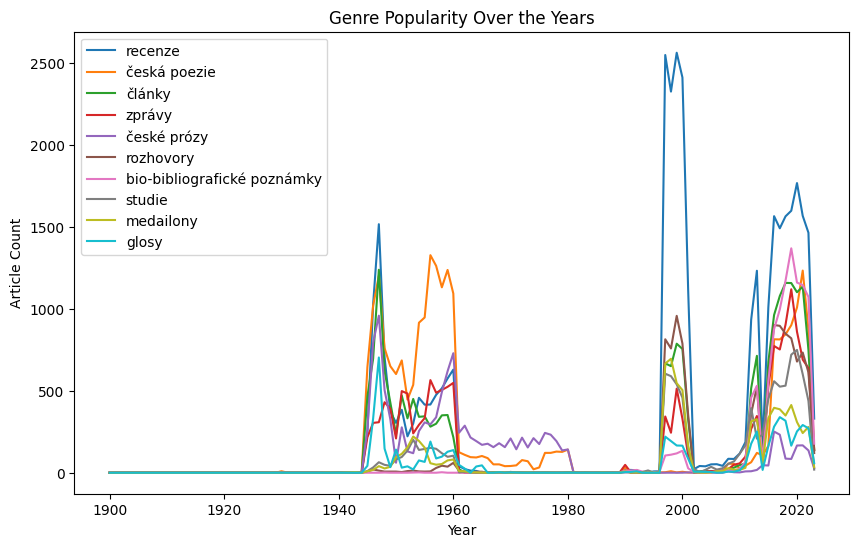

<Figure size 640x480 with 0 Axes>

In [47]:
import matplotlib.pyplot as plt

# Vytvoreni line chartu
plt.figure(figsize=(10, 6))  # Nastaveni velikosti

# Vykresleni linie pro kazdy element
for element in ten_most_common_elements:
    counts = [element_counts.get((element, year), 0) for year in years]
    plt.plot(years, counts, label=element)

# Pridame label a title
plt.xlabel('Year')
plt.ylabel('Article Count')
plt.title('{} Popularity Over the Years'.format(column.capitalize()))

# Pridame legendu
plt.legend()  

# Vykresleni
plt.show()

plt.savefig('plots/{}/{}_over_the_years'.format(database_type,column.capitalize()))


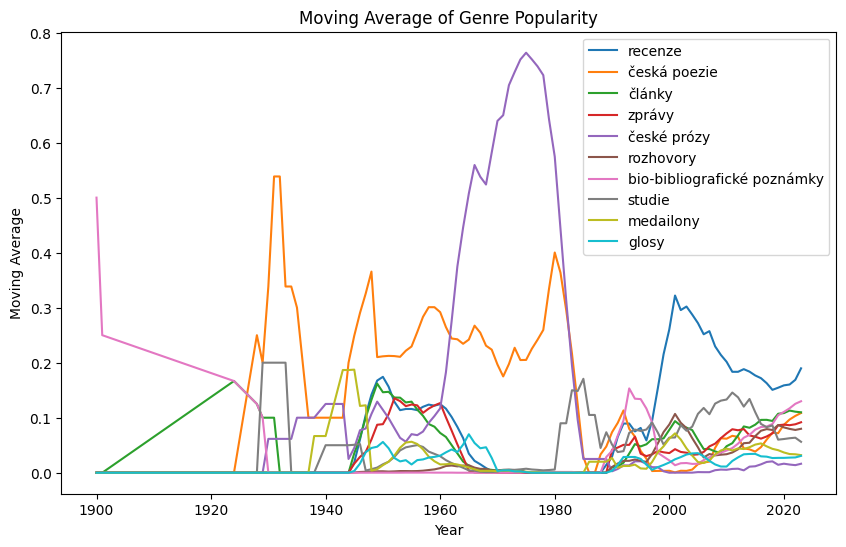

<Figure size 640x480 with 0 Axes>

In [48]:
# Vytvoreni line chartu
plt.figure(figsize=(10, 6))  # Nastaveni velikosti

proportions = {}
# Vykresleni linie pro kazdy element
for element in ten_most_common_elements:
    proportions[element] = [element_counts.get((element, year), 0) / total_counts[year] for year in years]

# Vypocteme moving average 
window_size = 5  # velikost okna
moving_averages = {}
for topic, values in proportions.items():
    moving_averages[topic] = pd.Series(values).rolling(window=window_size, min_periods=1).mean()


for element in ten_most_common_elements:    
    plt.plot(years, moving_averages[element], label=element)

# Pridame label a title
plt.xlabel('Year')
plt.ylabel('Moving Average')
plt.title('Moving Average of Genre Popularity')

# Pridame legendu
plt.legend()  

# Vykresleni
plt.show()

plt.savefig('plots/{}/moving_average_{}_over_the_years'.format(database_type,column.capitalize()))